In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyvista as pv
mesh = pv.read("~/code/uni/ushichka-registration/data/formatted/lidar_roi.ply")

pl = pv.Plotter(off_screen=False, notebook=False)
pl.add_mesh(mesh)
points = []
def onclick(point):
    points.append(point)
    print(f"picked {point}")
pl.enable_surface_picking(callback=onclick)
pl.show()

In [3]:
import numpy as np
points = np.array(points)
points

array([], dtype=float64)

In [4]:
picked_points = np.array([[-3.02017072,  1.91602907, -0.76811603],
       [-2.94146387,  1.97436807, -0.76497208],
       [-2.79947306,  2.0846709 , -0.7584722 ],
       [-2.95145778,  1.86817301, -0.93618609],
       [-2.88422545,  1.95260004, -0.94004291],
       [-2.79349747,  2.01736747, -0.94137936],
       [-2.90292026,  2.15166943, -0.804179  ],
       [-2.94026855,  2.20932992, -0.8097752 ],
       [-2.88185829,  2.13162774, -0.98856108],
       [-2.92712112,  2.21133655, -0.98735138]])

picked_cloud = pv.PolyData(picked_points)
picked_cloud["index"] = [f"{i}" for i in range(picked_points.shape[0])]
pl = pv.Plotter(off_screen=False, notebook=False)
pl.add_mesh(mesh)
pl.add_mesh(picked_cloud, color="green", point_size=25)
pl.add_point_labels(picked_cloud, "index", point_size=5, font_size=36)
points = []
def onclick(point):
    points.append(point)
    print(f"picked {point}")
pl.enable_surface_picking(callback=onclick)
pl.show()

In [5]:
from src.pycv.dmcp import dm_to_world
from src.experiment import Experiment
import scipy.linalg as la
exp = Experiment("/home/julian/data/dmcp_experiments/round_02/2018-08-19--cam1")
dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()
la.null_space(dmP) / la.null_space(dmP)[-1]

array([[-0.12298417],
       [ 2.07548531],
       [-0.18351529],
       [ 1.        ]])

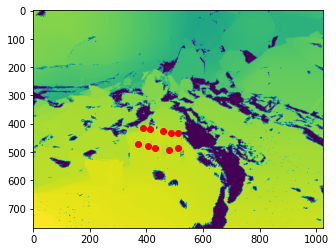

In [6]:
# observe picked points with dmP
picked_points_hat = np.hstack((picked_points,np.ones((picked_points.shape[0],1))))

projected_points = dmP @ picked_points_hat.T
projected_points = projected_points.T 
projected_points = np.array([projected_points[:,0] / projected_points[:,-1], projected_points[:,1] / projected_points[:,-1]]).T

import matplotlib.pyplot as plt

plt.imshow(dmIm, origin="upper",cmap="viridis_r")
plt.scatter(projected_points[:,0], projected_points[:,1],color="red")
plt.show()

In [7]:
from src.pycv.perspective import calibrate_dlt

P_calib = calibrate_dlt(projected_points, picked_points)
import scipy.linalg as la
la.null_space(P_calib) / la.null_space(P_calib)[-1]

array([[-0.12298417],
       [ 2.07548531],
       [-0.18351529],
       [ 1.        ]])

In [8]:
dm_to_world(dmIm, dmK, dmP, dmPts=projected_points)

array([[-3.0347853 ,  1.9152247 , -0.771065  ],
       [-2.9563813 ,  1.9738328 , -0.76804954],
       [-2.8402815 ,  2.084811  , -0.76723856],
       [-2.9736338 ,  1.8665476 , -0.94208723],
       [-2.9280736 ,  1.9506487 , -0.95205647],
       [-2.8148036 ,  2.0169039 , -0.94742584],
       [-2.788659  ,  2.148538  , -0.77866846],
       [-2.9294362 ,  2.2088153 , -0.80736727],
       [-3.4204364 ,  2.1425877 , -1.1457194 ],
       [-2.9270315 ,  2.2113323 , -0.9873257 ]], dtype=float32)

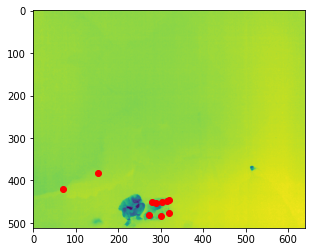

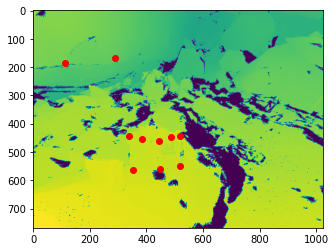

In [9]:
from src.pycv.dmcp import dmcp

imK = exp.load_imK()
imP = exp.load_imP()
imIm = exp.load_imIm()
cps = exp.load_cps()

plt.figure()
plt.imshow(imIm, cmap="viridis_r",origin="upper")
plt.scatter(cps[:,0],cps[:,1],c="red")
plt.show()

plt.figure()
plt.imshow(dmIm, cmap="viridis_r")
plt.scatter(cps[:,2],cps[:,3],c="red")
plt.show()



In [10]:
cps_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])
cps_world

array([[-2.9890945 ,  1.7919118 , -0.85127926],
       [-2.9856255 ,  1.9016805 , -0.88446367],
       [-2.8009856 ,  2.0492785 , -0.86243266],
       [-2.8943932 ,  2.1474495 , -0.85198087],
       [-2.9416196 ,  2.231462  , -0.8483608 ],
       [-2.8488607 ,  2.0534537 , -1.2059323 ],
       [-2.9205863 ,  2.222958  , -1.1998496 ],
       [-2.8050587 ,  1.8247212 , -1.1854005 ],
       [-5.3868976 ,  0.65060234,  0.12151396],
       [-5.9209237 ,  1.3323612 ,  0.23784496]], dtype=float32)

In [45]:
P_calib_dlt = calibrate_dlt(cps[:,:2], cps_world)

print("dlt calib")
la.null_space(P_calib) / la.null_space(P_calib)[-1]

dlt calib


array([[-1.55032094],
       [ 0.78316115],
       [-7.02409262],
       [ 1.        ]])

In [47]:
from src.pycv.perspective import solve_PnP
posemat = solve_PnP(cps_world, cps[:,:2], imK)

pose_matrix_hat = np.vstack((posemat, [0,0,0,1]))
extrinsic_matrix = la.inv(pose_matrix_hat)[:3,:]
P_calib_pnp = imK @ extrinsic_matrix
print(f"solve pnp pose\n{posemat}")

solve pnp pose
[[-0.69022363 -0.58153927  0.43058497 -1.55032094]
 [-0.72277001  0.52565869 -0.44864959  0.78316115]
 [ 0.03456662 -0.62088245 -0.7831412  -7.02409262]]


project cps into depth map is working:

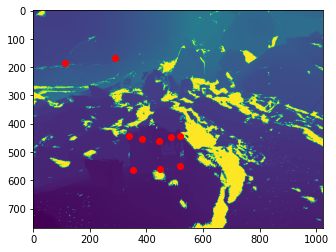

In [48]:
p_world_hat = np.hstack((cps_world,np.ones((cps_world.shape[0], 1))))

reprojs = dmP @ p_world_hat.T
reprojs = reprojs.T

reprojs = np.array([ reprojs[:,0] / reprojs[:,-1], reprojs[:,1] / reprojs[:,-1]  ]).T
reprojs

plt.imshow(dmIm)
plt.scatter(reprojs[:,0],reprojs[:,1],color="red")

however calibrated pose seems not valid

however dlt seems to work here

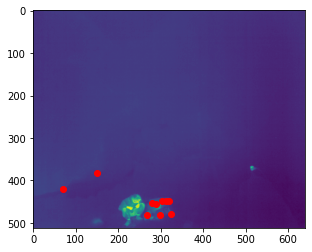

In [51]:

reprojs = P_calib_dlt @ p_world_hat.T
reprojs = reprojs.T
reprojs = np.array([ reprojs[:,0] / reprojs[:,-1], reprojs[:,1] / reprojs[:,-1]  ]).T

plt.imshow(imIm, origin="upper")
plt.scatter(reprojs[:,0],reprojs[:,1],color="red")

In [55]:
A = dmcp(imK, imP, cps[:,:2], cps_world)
A

estimated pose
[[-0.69022363 -0.58153927  0.43058497 -1.55032094]
 [-0.72277001  0.52565869 -0.44864959  0.78316115]
 [ 0.03456662 -0.62088245 -0.7831412  -7.02409262]]


array([[ 0.79689911, -0.58083719,  0.16607216, 36.38064817],
       [ 0.39023859,  0.70479039,  0.59243932, -4.42032027],
       [-0.46115686, -0.40730661,  0.78831192, 19.47557037],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

#### analyze result

In [56]:
# transfer
P_trans = imP @ la.inv(A)

la.null_space(P_trans) / la.null_space(P_trans)[-1]


array([[31.12962331],
       [-1.93184016],
       [18.11202768],
       [ 1.        ]])

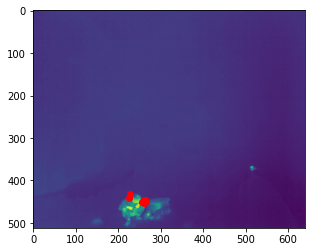

In [57]:
reprojs = P_trans @ p_world_hat.T
reprojs = reprojs.T
reprojs = np.array([ reprojs[:,0] / reprojs[:,-1], reprojs[:,1] / reprojs[:,-1]  ]).T

plt.imshow(imIm, origin="upper")
plt.scatter(reprojs[:,0],reprojs[:,1],color="red")